# Part 0: Preparations

### Import libraries

In [1]:
import pandas as pd 
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sn

from warnings import filterwarnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, LSTM, SpatialDropout1D, GlobalMaxPooling1D, Dense
from keras.layers import Embedding, Dropout, BatchNormalization, Concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


### Set random seed

In [2]:
np.random.seed(0)
tf.random.set_seed(0)

# Part 1: Import Data

In [3]:
# Import data
feature_train = pd.read_csv(r"D:\Tony\Programming\Datasets\Yelp\yelp_feature_train.csv", encoding='utf-8')
feature_val = pd.read_csv(r"D:\Tony\Programming\Datasets\Yelp\yelp_feature_val.csv", encoding='utf-8')
feature_test = pd.read_csv(r"D:\Tony\Programming\Datasets\Yelp\yelp_feature_test.csv", encoding='utf-8')

In [4]:
feature_train.shape, feature_val.shape, feature_test.shape

((428724, 18), (102135, 18), (129141, 18))

In [5]:
feature_train.head(3)

,business_id,user_id,review_stars,review_like,text,text_len,restaurant_avg_stars,restaurant_review_count,city_review_count,centrality,user_avg_stars,user_review_count,user_fans,user_period,user_compliments,user_votes,popularity,pop_label
0,oj8qk3W7O9oq15VIs-vYJQ,UreiTV1I9i-XF6_bJhK6Iw,5.0,0,new favorite place breakfast first time came h...,54,4.375000,64,436.0,2.207263e-21,3.55,104,0,8,2,80,4.694428,5.0
1,YFqlMM1tFn0C4b9aHdzOgg,UreiTV1I9i-XF6_bJhK6Iw,4.0,0,nice place food good nice wines pour decent si...,54,4.448276,29,839.0,2.207263e-21,3.55,104,0,8,2,80,4.367999,5.0
2,YFqlMM1tFn0C4b9aHdzOgg,UreiTV1I9i-XF6_bJhK6Iw,4.0,0,nice place food good nice wines pour decent si...,42,4.448276,29,839.0,2.207263e-21,3.55,104,0,8,2,80,4.367999,5.0


# Part 2: Feature Engineering

### Scale features

In [6]:
# Import scalers
scaler = StandardScaler()

# Select features
train_num = feature_train.loc[:,~feature_train.columns.isin(['business_id', 'user_id', 'text', 'popularity', 'pop_label'])]
val_num = feature_val.loc[:,~feature_val.columns.isin(['business_id', 'user_id', 'text', 'popularity', 'pop_label'])]
test_num = feature_test.loc[:,~feature_test.columns.isin(['business_id', 'user_id', 'text', 'popularity', 'pop_label'])]

# Fit scales
train_num_scale = scaler.fit_transform(train_num)
val_num_scale = scaler.transform(val_num)
test_num_scale = scaler.transform(test_num)

In [7]:
train_num_scale.shape, val_num_scale.shape, test_num_scale.shape

((428724, 13), (102135, 13), (129141, 13))

### Tokenize text sequence 

In [8]:
# Ref: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
# Set parameters
MAX_NB_WORDS = 100000
MAX_SEQ_LEN = 100

# Tokenize the texts
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(feature_train['text'])

# Transform tokens into sequences
sequences = tokenizer.texts_to_sequences(feature_train['text'])
train_text_seq = pad_sequences(sequences, maxlen=MAX_SEQ_LEN)
sequences = tokenizer.texts_to_sequences(feature_val['text'])
val_text_seq = pad_sequences(sequences, maxlen=MAX_SEQ_LEN)
sequences = tokenizer.texts_to_sequences(feature_test['text'])
test_text_seq = pad_sequences(sequences, maxlen=MAX_SEQ_LEN)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 134152 unique tokens.


### Import GloVe word vectors

In [9]:
# Read pre-trained GloVe file
embeddings_index = {}
f = open(r'D:\Tony\Programming\Datasets\GloVe\glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

# Link our index with GloVe index
embedding_matrix = np.zeros((len(word_index)+1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

### Define X-train and y-train

In [10]:
# Train set
X_train = [train_text_seq, train_num_scale]
y_train = pd.get_dummies(feature_train['pop_label'], drop_first=False).values

# Val set
X_val = [val_text_seq, val_num_scale]
y_val = pd.get_dummies(feature_val['pop_label'], drop_first=False).values

# Test set
X_test = [test_text_seq, test_num_scale]
y_test = pd.get_dummies(feature_test['pop_label'], drop_first=False).values

# Part 3: LSTM for Text Classification

### Build model

In [11]:
# LSTM
lstm_input = Input((MAX_SEQ_LEN,))
lstm_embed = Embedding(input_dim=len(word_index)+1, output_dim=100, 
                       weights=[embedding_matrix], input_length=MAX_SEQ_LEN, trainable=False)(lstm_input)
lstm_drop = SpatialDropout1D(0.2)(lstm_embed)
lstm_main = LSTM(100, dropout=0.2, recurrent_dropout=0.2)(lstm_drop)                 

# Other features
other_input = Input((13,))

# Concat models
merged = Concatenate()([lstm_main, other_input])
merged_FC1 = Dense(256, activation='softplus')(merged)
merged_norm1 = BatchNormalization()(merged_FC1)
merged_drop1 = Dropout(0.2)(merged_norm1)
merged_FC2 = Dense(8, activation='softplus')(merged_drop1)
merged_norm2 = BatchNormalization()(merged_FC2)
merged_drop2 = Dropout(0.2)(merged_norm2)
merged_out = Dense(5, activation='softmax')(merged_drop2)
concat_model = Model(inputs=[lstm_input, other_input], outputs=merged_out)

# Model summary
concat_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 100)     13415300    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 100, 100)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 100)          80400       spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

### Train model

In [12]:
filterwarnings("ignore", category=UserWarning)

# Set training parameters
EPOCHS = 50
BATCH_SIZE = 64
Adam = Adam(learning_rate=2e-4)

# Compile model
concat_model.compile(loss='categorical_crossentropy', optimizer=Adam)

# Train model
history = concat_model.fit(
    X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
    validation_data=(X_val, y_val), verbose=1, shuffle=True, 
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)]
)

Train on 428724 samples, validate on 102135 samples
Epoch 1/50
428724/428724 [==============================] - 556s 1ms/step - loss: 0.9791 - val_loss: 0.9042
Epoch 2/50
428724/428724 [==============================] - 567s 1ms/step - loss: 0.8496 - val_loss: 0.8822
Epoch 3/50
428724/428724 [==============================] - 552s 1ms/step - loss: 0.8315 - val_loss: 0.8729
Epoch 4/50
428724/428724 [==============================] - 563s 1ms/step - loss: 0.8244 - val_loss: 0.8681
Epoch 5/50
428724/428724 [==============================] - 592s 1ms/step - loss: 0.8189 - val_loss: 0.8687
Epoch 6/50
428724/428724 [==============================] - 547s 1ms/step - loss: 0.8161 - val_loss: 0.8590
Epoch 7/50
428724/428724 [==============================] - 577s 1ms/step - loss: 0.8118 - val_loss: 0.8587
Epoch 8/50
428724/428724 [==============================] - 569s 1ms/step - loss: 0.8104 - val_loss: 0.8546
Epoch 9/50
428724/428724 [==============================] - 564s 1ms/step - loss: 0.

### Plot training history

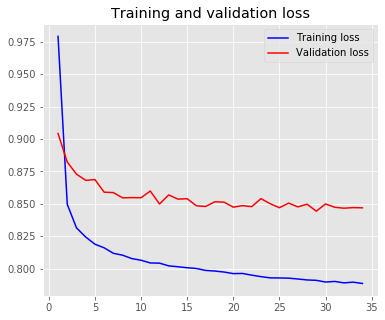

In [13]:
# Reference: https://realpython.com/python-keras-text-classification/#a-primer-on-deep-neural-networks
plt.style.use('ggplot')
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)

    plt.figure(figsize=(6, 5))
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

# Part 4: Model Validation

### Aggregate test predictions by restaurant

In [17]:
# parameters for testing
feature = feature_test
X = X_test
y = y_test

# fit model on test set
# if you use packages different from keras, please make sure that pred is n x 5 array
pred = concat_model.predict(X)

# pseudo-Gaussian product
res_weight = pd.DataFrame(feature.iloc[:,0])
res_weight['1'] = 1
res_weight['2'] = 2
res_weight['3'] = 3
res_weight['4'] = 4
res_weight['5'] = 5
res_weight[['p1', 'p2', 'p3', 'p4', 'p5']] = pd.DataFrame(pred)
res_weight['mean'] = res_weight['1']*res_weight['p1'] + \
                     res_weight['2']*res_weight['p2'] + \
                     res_weight['3']*res_weight['p3'] + \
                     res_weight['4']*res_weight['p4'] + \
                     res_weight['5']*res_weight['p5']
res_weight['var'] = res_weight['p1']*((res_weight['1']-res_weight['mean'])**2) + \
                    res_weight['p2']*((res_weight['2']-res_weight['mean'])**2) + \
                    res_weight['p3']*((res_weight['3']-res_weight['mean'])**2) + \
                    res_weight['p4']*((res_weight['4']-res_weight['mean'])**2) + \
                    res_weight['p5']*((res_weight['5']-res_weight['mean'])**2)
res_weight['repvar'] = 1/res_weight['var']
res_weight['w_mean'] = res_weight['mean']*res_weight['repvar']

# aggregate reviews by restaurants 
gb = res_weight.groupby(['business_id']).sum()
gb['grand_mean'] = gb['w_mean']/gb['repvar']
gb['grand_var'] = 1/gb['repvar']

# aggregate true labels by restaurants
y_true = pd.DataFrame(feature.iloc[:,[0]])
y_true[['y_1', 'y_2', 'y_3', 'y_4', 'y_5']] = pd.DataFrame(y)
y_gb = y_true.groupby(['business_id']).mean()

# combine prediction and true labels for restaurants
pred_mx = pd.merge(gb, y_gb, how='left', on=['business_id'])

### Calculate RMSE

In [18]:
# calculate RMSE
true_labs = pred_mx[['y_1', 'y_2', 'y_3', 'y_4', 'y_5']].to_numpy().argmax(axis=1)+1
pred_labs = np.round(pred_mx['grand_mean'])
rmse = (mean_squared_error(true_labs, pred_labs))**(0.5)
print("RMSE:\t", round(rmse, 4))

RMSE:	 0.9813


### Confusion matrix

Text(0.5, 1, 'Confusion Matrix')

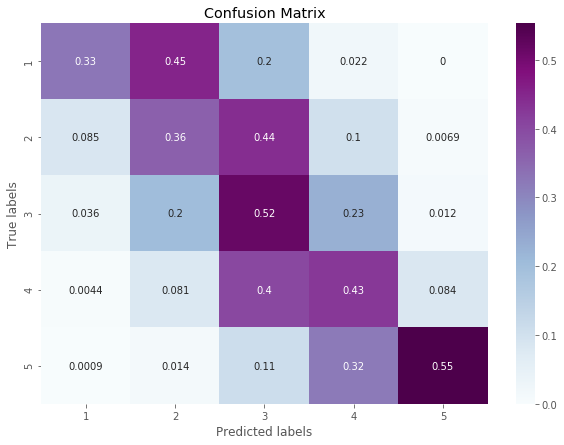

In [19]:
# plot confusion matrix
labels = [1,2,3,4,5]
cm = confusion_matrix(true_labs, pred_labs, labels, normalize='true')
cm_df = pd.DataFrame(cm, index=[i for i in labels], columns=[i for i in labels])

plt.figure(figsize = (10,7))
ax = plt.subplot()
sn.heatmap(cm_df, annot=True, cmap='BuPu', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')